In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [184]:
backbone1 = []
fn = "/home/robert/data/mode_s_ts_1_nb_10000_seed_34_.dat"
print('reading', fn)
with open(fn, 'r') as fid:
    for row in fid:
        row = row.split()
        # extract the fiber center (rectangular trapezoid)
        v = np.zeros(5)
        if -8 <= int(row[2]) <=8:
            if -8 <= int(row[4]) <=8:
                if -100 <= int(row[3]) <=100:
                    #print(row)
                    v = [
                        int(row[1]),  # particle id
                        int(row[2]),  # x
                        int(row[3]),  # y
                        int(row[4]),  # z                        
                    ]
                    backbone1.append(v)

backbone1 = np.array(backbone1, dtype=np.int32)
# print(back_bone1)
# np.savetxt('./testeback.txt',backbone1,fmt='%f')

reading /home/robert/data/mode_s_ts_1_nb_10000_seed_34_.dat


In [5]:
with open("/home/robert/gitrepos/dla-collagen/back_bone_teste.txt", 'w') as fid:
    for i in backbone1:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

FileNotFoundError: [Errno 2] No such file or directory: '/home/robert/gitrepos/dla-collagen/back_bone_teste.txt'

In [191]:
def generate_all_neigh(new):
    #Gera o vetor com 4 vizinhos de cada sítio
    new1 = new.copy()
    new2 = new.copy()
    new3 = new.copy()
    new4 = new.copy()

    new1[:,0] = new1[:,0] + 1
    new2[:,0] = new2[:,0] - 1
    new3[:,2] = new3[:,2] + 1
    new4[:,2] = new4[:,2] - 1

    #Junta tudo em um array
    new0 = np.vstack((new,new1))
    new0 = np.vstack((new0,new2))
    new0 = np.vstack((new0,new3))
    new0 = np.vstack((new0,new4))
    return new0

In [196]:
def filter_backbone(backbone1:np.ndarray, ascending:bool=True):
    xidx, yidx, zidx = 1, 2, 3
    # boolean indicating if the particle is in the backbone
    b = np.zeros(backbone1.shape[0], dtype=np.int8)
    
    # sort backbone1 by y coordinate
    backbone1 = backbone1[backbone1[:,yidx].argsort()]

    yMin = np.min(backbone1[:,yidx])
    yMax = np.max(backbone1[:,yidx])
    
    yLayer = yMin if ascending else yMax

    yRange = range(yMin+1, yMax+1) if ascending else range(yMax-1, yMin-1, -1)
    
    # find all particles in the current layer
    idx_prev = np.where(backbone1[:,yidx] == yLayer)[0]
    print('primeira camada: %d' %len(idx_prev))
    # mark the particles in the current layer that are neighbors of the previous layer
    b[idx_prev] = 1
    
    for yLayer in yRange:
        
        # find all particles in the current layer
        idx = np.where(backbone1[:,yidx] == yLayer)[0]
        print('camada %d: %d' %(yLayer,len(idx)))
        # for all particle in the current layer, check if they are neighbors of the previous layer
        idxB = []
        for i in idx:
            xzB = backbone1[i][[xidx, zidx]]
            for j in idx_prev:
                xzP = backbone1[j][[xidx, zidx]]
                if np.all(xzB == xzP):
                    idxB.append(i)
                    break
        # raise exception if idxB is empty
        if len(idxB) == 0:
            raise Exception('No particles found on layer %d' % yLayer)
        print('quantos na camada %d tem vizinhos na camada %d: %d' %(yLayer, yLayer - 1, len(idxB)) )
        # find neighbors in current layer considering xidx and zidx
        xzB = backbone1[idxB][:,[xidx,zidx]]
        idxL = list(set(idx) - set(idxB)) # index of particles in the level but not in idxB
        xzN = backbone1[idxL][:,[xidx,zidx]]
        idxN = [] # list of indices of particles to be added
        for k, i in enumerate(idxL):
            xzn = xzN[k]
            keep = False
            # searching for neighbors of each partcile in the current layer
            for xzb in xzB:
                if np.sum(np.abs(xzn-xzb)) == 1:
                    print('entrou')
                    # there is a neighbor in the current layer
                    keep = True
                    break
            if keep:
                idxN.append(i)

        # mark the particles in the current layer that are neighbors of the previous layer
        idx_prev = np.array(idxB + idxN, dtype=np.int32)
        
        #print('total adicionado ao backbone: %d' %len(idx_prev))
        b[idx_prev] = 1
    return backbone1[b==1]

In [199]:
## Test for filter_backbone

m = [[0,0,0,1], [1,1,0,1], [2, 2, 0, 1], [3, 1, 0, 3], [4, 1,1,1], [5, 2, 1, 1], [6, 2,1,1], [7, 0,1,1], [8, 1,1,2],[9, 3, 1, 1], [10, 2, 1, 0], [11, 5, 1, 1]
, [12, 0, 1, 4],   [13, 0, 2, 4] ]
v = np.array(m, dtype=np.int8)

v = v[v[:,2].argsort()]
print(v)

bt = filter_backbone(v, ascending= False)


[[ 0  0  0  1]
 [ 1  1  0  1]
 [ 2  2  0  1]
 [ 3  1  0  3]
 [ 4  1  1  1]
 [ 5  2  1  1]
 [ 6  2  1  1]
 [ 7  0  1  1]
 [ 8  1  1  2]
 [ 9  3  1  1]
 [10  2  1  0]
 [11  5  1  1]
 [12  0  1  4]
 [13  0  2  4]]
primeira camada: 1
camada 1: 9
quantos na camada 1 tem vizinhos na camada 0: 1
camada 0: 4


Exception: No particles found on layer 0

In [186]:
## Filter fibril
bb2 = filter_backbone(backbone1, ascending=True)
print('subiu')
bb3 = filter_backbone(bb2, ascending=False)
print('desceu')

subiu
desceu


In [187]:
print(len(backbone1))
print(len(bb3))

10916
5700


In [204]:
def filter_(back_bone1,inicial):
    camada = backbone1[backbone1[:,2] == inicial]
    while(len(camada)!=0):
        acima = np.copy(camada)
        acima[:,2] = acima[:,2] + 1
        

In [205]:
filter_(back_bone1,-100)

[[  46   -2 -100    0]
 [  68   -3 -100    0]
 [  96   -2 -100    2]
 [ 101   -1 -100    2]
 [ 104   -3 -100    2]
 [ 107   -3 -100   -1]
 [ 136    2 -100   -1]
 [ 137   -4 -100    0]
 [ 159   -4 -100   -1]
 [ 170   -4 -100    3]
 [ 215   -2 -100   -1]
 [ 220    1 -100   -2]
 [ 231    1 -100   -3]
 [ 245    1 -100    2]
 [ 288   -4 -100    4]
 [ 298    1 -100   -4]
 [ 311   -4 -100    1]
 [ 369    0 -100    3]
 [ 508   -2 -100   -2]
 [ 600   -2 -100   -4]
 [ 615   -5 -100   -1]
 [ 616    7 -100    2]
 [ 630    2 -100   -3]
 [ 754    7 -100    3]
 [ 786   -4 -100    5]
 [ 822   -8 -100   -1]
 [ 887   -2 -100   -5]
 [ 963    3 -100   -3]
 [1010   -3 -100    5]
 [1219   -4 -100    2]
 [1845    2 -100    1]
 [1905   -4 -100   -8]
 [1977   -4 -100    6]
 [2004    6 -100    3]
 [2074    6 -100    4]
 [2106    6 -100    5]
 [2111    1 -100   -5]
 [2357   -7 -100    6]
 [2384   -4 -100   -5]
 [2465   -4 -100    7]
 [2824    7 -100    5]
 [3082    2 -100    5]
 [3196    5 -100   -2]
 [3254   -4

In [607]:
backbone1 = np.array(bb3).astype(int)
back_bone,N = filter_backbone(backbone1,-100,+1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone])
back_bone,N = filter_backbone(back_bone,100,-1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone]).astype(int)

In [218]:
bb3
sitio = np.array(bb3[bb3.astype(int)[:,0] == 46].astype(int))[: ,1:]
print(sitio)
a = np.unique(sitio[:,0], return_counts = True)[0]
print(a)

[[  -2 -100    0]
 [  -2  -99    0]
 [  -2  -98    0]
 [  -2  -97    0]
 [  -2  -96    0]
 [  -2  -95    0]
 [  -2  -94    0]
 [  -2  -93    0]
 [  -2  -92    0]
 [  -2  -91    0]
 [  -2  -90    0]
 [  -2  -89    0]
 [  -2  -88    0]]
[-2]


In [278]:
def generate_probability(back_bone,F = 1,sigma_c = 1,m = 1):
    ids = np.unique(back_bone[:,0],return_counts=True)[0].astype(int)
    number = np.unique(back_bone[:,0],return_counts=True)[1].astype(int)
    ids = ids[np.argsort(number)[::-1]]
    number = number[np.argsort(number)[::-1]]
    probabilidade = []
    back_bone = back_bone.astype(int)
    for id in ids:

        sitio = np.array(back_bone[back_bone[:,0] == id])[:,1:]
        vizinhos = [back_bone[np.sum(i - back_bone[:,1:]**2,axis = 1) == 1].tolist() for i in sitio]
        vizinhos = [i for i in vizinhos if(i != [])]
        vizinhos = [item for sublist in vizinhos for item in sublist]
        vizinhos = np.array([i for i in vizinhos if(i[0] != id)])
        n = np.array([len(back_bone[back_bone[:,2] == i[1]]) for i in sitio])

        n = F/n
        sigma_ = np.mean(n)

        n_ = len(np.unique(vizinhos[:,0]))
        print(vizinhos[:,0])
        P = (sigma_/n_*sigma_c)**m
        probabilidade.append([id,P,len(sitio)])
    probabilidade = np.array(probabilidade)
    return probabilidade

In [593]:
def remover(vetor,elemento):
    a = np.arange(len(vetor))
    a = a[vetor == elemento]
    print(a)
    return a

In [599]:
back_bone

array([[ 237,   -4,  100,    4,    0],
       [2213,   -2,  100,   -7,    0],
       [3577,   -2,  100,   -5,    0],
       ...,
       [2660,    1, -100,   -8,    0],
       [5179,    4, -100,    1,    0],
       [ 979,   -5, -100,   -5,    0]])

In [279]:
t = []
back_bone1 = np.copy(bb3)
for F in range(0,110,10):
    
    print(F)
    probabilidade = generate_probability(back_bone1,F,sigma_c = 1,m = 2)
    remove_ = probabilidade[probabilidade[:,1] >= 1][:,0]
    probabilidade = probabilidade[probabilidade[:,1] < 1]

    for i in remove_:
        back_bone1 = back_bone1[back_bone1[:,0] != i]
    t.append(np.sum(probabilidade[:,-1]))
    print(t)
t = np.array(t)

0
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  0  0 

KeyboardInterrupt: 

In [597]:
t

array([3331., 3330., 3321., 3307., 3255., 3229., 3210., 3181., 3127.,
       3078., 2981.])

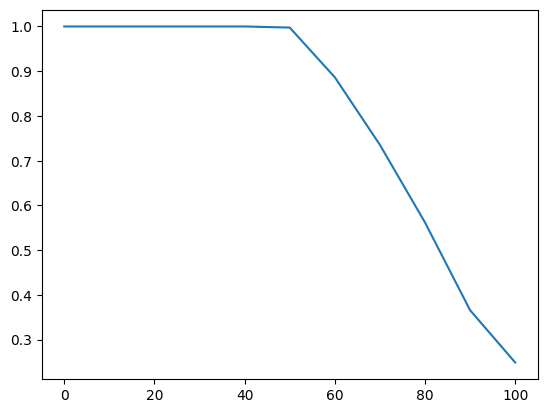

In [277]:
plt.plot(np.array(range(0,110,10)),t/t[0])
plt.show()

In [443]:
backbone = back_bone.astype(int)

In [448]:
back_bone[back_bone[:,2] == 10]

array([[182.,   0.,  10.,  -5.,   0.],
       [ 22.,   1.,  10.,   2.,   0.],
       [  4.,   1.,  10.,  -1.,   0.],
       [ 37.,   0.,  10.,   1.,   0.],
       [ 53.,   0.,  10.,  -4.,   0.],
       [  8.,   2.,  10.,  -1.,   0.],
       [156.,   3.,  10.,  -1.,   0.],
       [ 89.,  -1.,  10.,   1.,   0.],
       [125.,   3.,  10.,  -2.,   0.],
       [ 30.,   1.,  10.,   3.,   0.]])

[array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape

In [ ]:
with open("/home/robert/gitrepos/dla-collagen/back_bone_teste.txt", 'w') as fid:
    for i in back_bone1:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

In [ ]:
np.savetxt("./back.txt", back_bone[:,1:-1],fmt = "%d", delimiter=' ')

In [ ]:
back_bone

array([[ 237,   -4,  100,    4,    0],
       [2213,   -2,  100,   -7,    0],
       [3577,   -2,  100,   -5,    0],
       ...,
       [2660,    1, -100,   -8,    0],
       [5179,    4, -100,    1,    0],
       [ 979,   -5, -100,   -5,    0]])

In [ ]:
##

F = 1
stress_i = np.array(201)


array([[  1, -99,   0],
       [  0, -99,   0],
       [ -1, -99,   1],
       [ -1, -99,  -4],
       [ -2, -99,  -4],
       [  0, -99,  -4],
       [  0, -99,  -3],
       [  4, -99,  -2],
       [ -4, -99,   1],
       [ -3, -99,   1],
       [  5, -99,  -2],
       [ -5, -99,   0],
       [ -3, -99,   0],
       [  2, -99,   2],
       [ -6, -99,   0],
       [ -7, -99,   0],
       [  3, -99,  -7],
       [ -7, -99,  -1],
       [  5, -99,  -1],
       [  5, -99,   0],
       [  6, -99,  -1],
       [  0, -99,   6],
       [ -3, -99,  -4],
       [  1, -99,  -4],
       [ -4, -99,  -4],
       [  6, -99,  -5],
       [  7, -99,  -5],
       [ -5, -99,  -4],
       [  0, -99,   7],
       [ -4, -99,  -5],
       [  6, -99,  -4],
       [  9, -99,  -7],
       [  7, -99,  -4],
       [  5, -99,   6],
       [  9, -99,  -8],
       [ -1, -99,   7],
       [  8, -99,  -8],
       [ -2, -99,   7],
       [  5, -99,   7],
       [ -7, -99,   4],
       [  8, -99,  -4],
       [  7, -99

(47, 3)

In [ ]:
#print(len(back_bone1))
back_bone2 = []
print('tamanho back_bone1: %d' %len(back_bone1))

### Encotra todas as part. da primeira camada(y = -100) e marca como conectado
for j in back_bone1:
            
    if j[2] == -100:
        #print(entrou)
        part = [j[0], j[1], j[2], j[3], j[4] +1]
        back_bone2.append(part)
        #print(back_bone2)

    else:
        continue

### Encontra os vizinhos na segunda camada das part. marcadas na primeira camada
layer = []
plane = []
for i in back_bone2:
    part = [i[0], i[1], i[2]  + 1, i[3], i[4]]
    
    for j in back_bone1:

        if part[1] == j[1] and part[2] == j[2] and part[3] == j[3]:
            part[4] = 1
            layer.append(part)
        
print(len(layer))

### Encontra os vizinhos das part. na segunda camada
print(len(layer))
for i in layer:
    neigh1 = [i[0], i[1] + 1, i[2], i[3], i[4]]
    neigh2 = [i[0], i[1] - 1, i[2], i[3], i[4]]
    neigh3 = [i[0], i[1], i[2], i[3] + 1, i[4]]
    neigh4 = [i[0], i[1], i[2], i[3] - 1, i[4]]


    for j in back_bone1:

        if neigh1[1] == j[1]:
            if neigh1[2] == j[2]:
                if neigh1[3] == j[3]:
                    neigh1[4] = 1
                    layer.append(neigh1)

        if neigh2[1] == j[1]:
            if neigh2[2] == j[2]:
                if neigh2[3] == j[3]:
                    neigh2[4] = 1
                    layer.append(neigh2)

        if neigh3[1] == j[1]:
            if neigh3[2] == j[2]:
                if neigh3[3] == j[3]:
                    neigh3[4] = 1
                    layer.append(neigh3)

        if neigh4[1] == j[1]:
            if neigh4[2] == j[2]:
                if neigh4[3] == j[3]:
                    neigh4[4] = 1
                    layer.append(neigh4)



        

#print('plane: %d' %len(plane))
print(len(layer))
### Adiciona as part. conectadas da segunda camada no back_bone2


tamanho back_bone1: 8431
45
45


KeyboardInterrupt: 

In [ ]:
for i in back_bone1:
    if i[2] == -99:
        #print(i)
        #print(type(i))
        c = 0
a = [112, -1, -98, 1, 0]
if a in back_bone1:
    print("ok")
else:
    print('no')


no


In [ ]:
part = [51.0, 0.0, -99.0, 0.0, 1]
for i in back_bone1:
    if part[1] == i[1] and part[2] == i[2] and part[3] == i[3]:
        print(part)
        print(i)

[51.0, 0.0, -99.0, 0.0, 1]
[51.0, 0.0, -99.0, 0.0, 0.0]


In [ ]:
for i in back_bone1:

    if i[2] == -99:
        print(i)

[51.0, 0.0, -99.0, 0.0, 0.0]
[112.0, -2.0, -99.0, 1.0, 0.0]
[136.0, -2.0, -99.0, -4.0, 0.0]
[138.0, -3.0, -99.0, -4.0, 0.0]
[144.0, -1.0, -99.0, -4.0, 0.0]
[171.0, -1.0, -99.0, -3.0, 0.0]
[196.0, 3.0, -99.0, -2.0, 0.0]
[248.0, -5.0, -99.0, 1.0, 0.0]
[287.0, 4.0, -99.0, -2.0, 0.0]
[302.0, -6.0, -99.0, 0.0, 0.0]
[313.0, -4.0, -99.0, 0.0, 0.0]
[338.0, 1.0, -99.0, 2.0, 0.0]
[355.0, 4.0, -99.0, -5.0, 0.0]
[414.0, -7.0, -99.0, 0.0, 0.0]
[417.0, -8.0, -99.0, 0.0, 0.0]
[420.0, 2.0, -99.0, -7.0, 0.0]
[437.0, -8.0, -99.0, -1.0, 0.0]
[438.0, 4.0, -99.0, -1.0, 0.0]
[458.0, 4.0, -99.0, 0.0, 0.0]
[470.0, 5.0, -99.0, -1.0, 0.0]
[549.0, -4.0, -99.0, 5.0, 0.0]
[553.0, -1.0, -99.0, 6.0, 0.0]
[584.0, -4.0, -99.0, -4.0, 0.0]
[674.0, 0.0, -99.0, -4.0, 0.0]
[698.0, -5.0, -99.0, -4.0, 0.0]
[704.0, 5.0, -99.0, -5.0, 0.0]
[758.0, 6.0, -99.0, -5.0, 0.0]
[764.0, -6.0, -99.0, -4.0, 0.0]
[905.0, -1.0, -99.0, 7.0, 0.0]
[979.0, -5.0, -99.0, -5.0, 0.0]
[1003.0, 5.0, -99.0, -4.0, 0.0]
[1046.0, 8.0, -99.0, -7.0, 0.0]
[

In [ ]:
#print(back_bone2)
with open("/home/robert/gitrepos/dla-collagen/back_bone2_teste.txt", 'w') as fid:
    for i in back_bone2:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

[[51.0, 0.0, -99.0, 0.0, 0], [67.0, -1.0, -99.0, 0.0, 0], [112.0, -2.0, -99.0, 1.0, 0], [136.0, -2.0, -99.0, -4.0, 0], [138.0, -3.0, -99.0, -4.0, 0], [144.0, -1.0, -99.0, -4.0, 0], [171.0, -1.0, -99.0, -3.0, 0], [196.0, 3.0, -99.0, -2.0, 0], [248.0, -5.0, -99.0, 1.0, 0], [271.0, -4.0, -99.0, 1.0, 0], [287.0, 4.0, -99.0, -2.0, 0], [302.0, -6.0, -99.0, 0.0, 0], [313.0, -4.0, -99.0, 0.0, 0], [338.0, 1.0, -99.0, 2.0, 0], [414.0, -7.0, -99.0, 0.0, 0], [417.0, -8.0, -99.0, 0.0, 0], [420.0, 2.0, -99.0, -7.0, 0], [437.0, -8.0, -99.0, -1.0, 0], [438.0, 4.0, -99.0, -1.0, 0], [458.0, 4.0, -99.0, 0.0, 0], [470.0, 5.0, -99.0, -1.0, 0], [553.0, -1.0, -99.0, 6.0, 0], [584.0, -4.0, -99.0, -4.0, 0], [674.0, 0.0, -99.0, -4.0, 0], [698.0, -5.0, -99.0, -4.0, 0], [704.0, 5.0, -99.0, -5.0, 0], [758.0, 6.0, -99.0, -5.0, 0], [764.0, -6.0, -99.0, -4.0, 0], [905.0, -1.0, -99.0, 7.0, 0], [979.0, -5.0, -99.0, -5.0, 0], [1003.0, 5.0, -99.0, -4.0, 0], [1046.0, 8.0, -99.0, -7.0, 0], [1065.0, 6.0, -99.0, -4.0, 0], [1